In [ ]:
!pip install PyPDF2
!pip install PyMuPDF
!pip install llama_index
!pip install git+https://github.com/openai/CLIP.git
!pip matplotlib qdrant_client

In [ ]:
%pip install llama-index-vector-stores-qdrant llama-index-readers-file llama-index-embeddings-fastembed llama-index-llms-openai
%pip install llama-index-embeddings-clip
%pip install -U langchain-community
%pip install llama-index-embeddings-huggingface
%pip install llama-index-embeddings-langchain
%pip install llama-index-vector-stores-qdrant
%pip install llama_index ftfy regex tqdm
%pip install matplotlib scikit-image
%pip install -U qdrant_client
%pip install llama-index-readers-file
%pip install google-generativeai>=0.3.0
%pip install llama-index-multi-modal-llms-gemini
%pip install llama-index-embeddings-gemini
%pip install llama-index-llms-gemini

In [40]:
import requests
import PyPDF2
import fitz
from PIL import Image
import matplotlib.pyplot as plt
import io
import os
from google.colab import userdata
import glob
import pandas as pd
from llama_index.core import SimpleDirectoryReader

from llama_index.core.node_parser import (
    SentenceSplitter,
    SemanticSplitterNodeParser,
)
from llama_index.embeddings.openai import OpenAIEmbedding

import warnings
warnings.filterwarnings('ignore')

In [41]:
OPENAI_API_KEY = userdata.get('OPENAI')
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY
GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')
os.environ["GOOGLE_API_KEY"] = GEMINI_API_KEY

In [42]:
def download_pdf(url, file_name):

    response = requests.get(url)
    if response.status_code == 200:
        with open(file_name, "wb") as f:
            f.write(response.content)
    else:
        print(response.status_code)


if __name__ == "__main__":

    url = "https://arxiv.org/pdf/2401.04088"
    file_name = "mixtral.pdf"
    download_pdf(url, file_name)

In [43]:
if not os.path.exists('pdf_pages/'):
    os.makedirs('pdf_pages/')

pdf_document = fitz.open(file_name)

for page_number in range(pdf_document.page_count):
    page = pdf_document[page_number]
    pix = page.get_pixmap()
    image = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
    image.save(f"./pdf_pages/page_{page_number + 1}.png")

pdf_document.close()

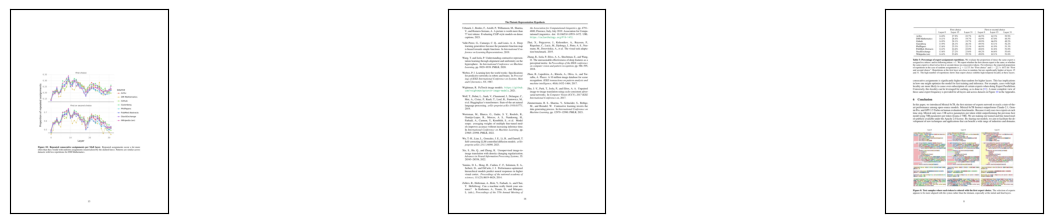

In [44]:
image_paths = []
for img_path in os.listdir("pdf_pages"):
    image_paths.append(str(os.path.join("pdf_pages", img_path)))


def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in image_paths:
        if os.path.isfile(img_path):
            image = Image.open(img_path)

            plt.subplot(3, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 9:
                break


plot_images(image_paths[9:12])

In [45]:
def extract_text_from_pdf(file_path, save_dir='pdf_content/'):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    with open(file_path, 'rb') as file:
        reader = PyPDF2.PdfReader(file)
        page_text = []
        for i, page in enumerate(reader.pages):
            extracted_text = page.extract_text()
            if extracted_text:
                text_path = os.path.join(save_dir, f'page_{i+1}.txt')
                with open(text_path, 'w') as text_file:
                  text_file.write(extracted_text)
                page_text.append(extracted_text)
        return page_text

pdf_file_path = '/content/mixtral.pdf'
extracted_text = extract_text_from_pdf(pdf_file_path)

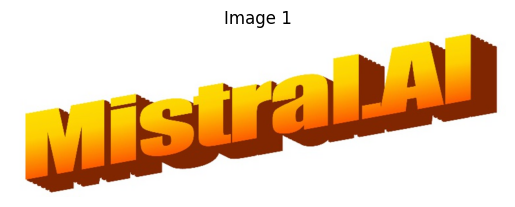

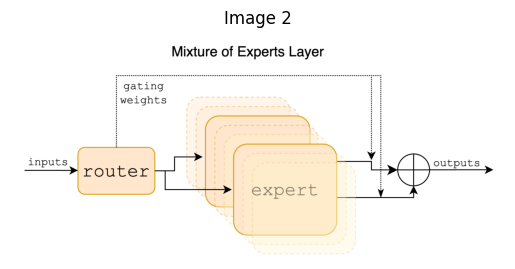

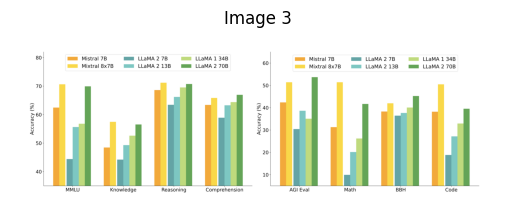

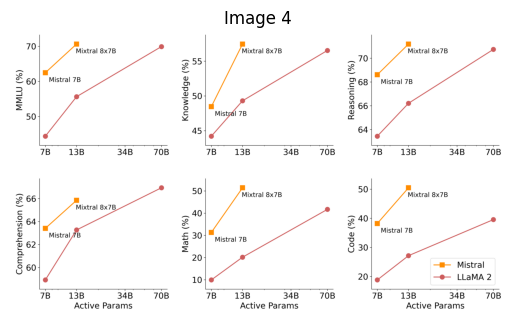

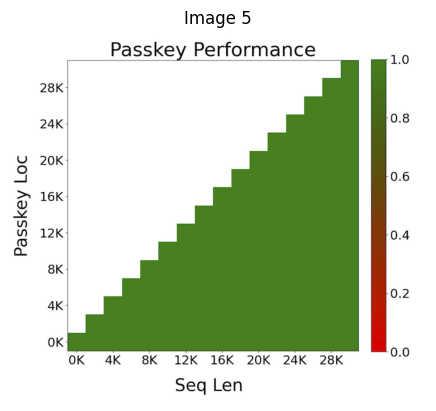

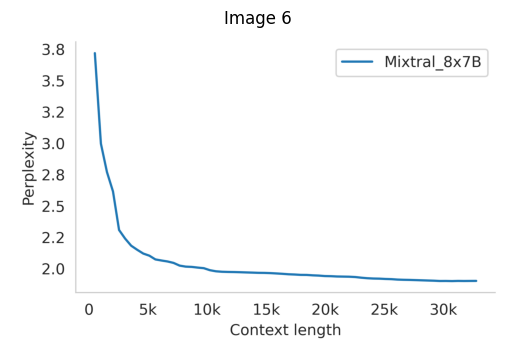

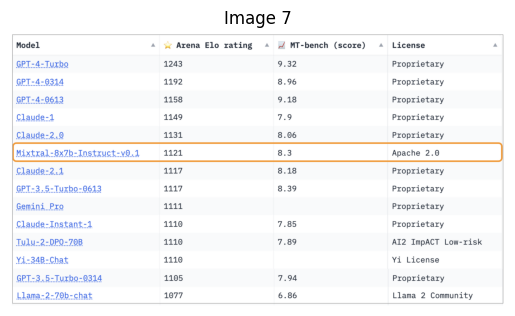

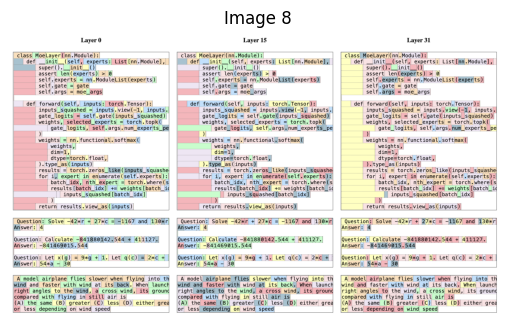

In [46]:
def extract_images_from_pdf(pdf_path, save_dir='pdf_content2/'):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    doc = fitz.open(pdf_path)
    images = []
    for page_num in range(len(doc)):
        page = doc.load_page(page_num)
        for img in page.get_images(full=True):
            xref = img[0]
            base_image = doc.extract_image(xref)
            image_bytes = base_image["image"]
            images.append(image_bytes)

            image_path = os.path.join(save_dir, f'image_{page_num+1}_{xref}.png')
            with open(image_path, 'wb') as img_file:
                img_file.write(image_bytes)

    for i, img_bytes in enumerate(images):
        with io.BytesIO(img_bytes) as img_io:
            img = Image.open(img_io)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f'Image {i+1}')
            plt.show()

    return images

pdf_path = '/content/mixtral.pdf'
images = extract_images_from_pdf(pdf_path)

In [ ]:
documents = SimpleDirectoryReader("/content/pdf_content").load_data()

In [ ]:
embed_model = OpenAIEmbedding()
splitter = SemanticSplitterNodeParser(
    buffer_size=1, breakpoint_percentile_threshold=95, embed_model=embed_model, max_chunk_size = 512
)

In [ ]:
from torchvision import transforms
import torch
import qdrant_client
from llama_index.core import SimpleDirectoryReader
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index.core import VectorStoreIndex, StorageContext
from llama_index.core.indices import MultiModalVectorStoreIndex
from llama_index.multi_modal_llms.openai import OpenAIMultiModal

openai_mm_llm = OpenAIMultiModal(
    model="gpt-4o", api_key=OPENAI_API_KEY, max_new_tokens=300
)

# Create a local Qdrant vector store
client = qdrant_client.QdrantClient(path="qdrant_mm_db")

text_store = QdrantVectorStore(
    client=client, collection_name="text_collection"
)
image_store = QdrantVectorStore(
    client=client, collection_name="image_collection"
)
storage_context = StorageContext.from_defaults(
    vector_store=text_store, image_store=image_store
)

index = MultiModalVectorStoreIndex(
    nodes,
    api_key=OPENAI_API_KEY,
    storage_context=storage_context,
)

# Save it
index.storage_context.persist(persist_dir="./storage")

In [ ]:
from llama_index.llms.gemini import Gemini

gemini = Gemini(model = "models/gemini-1.5-pro-latest")

In [ ]:
from llama_index.core.indices.query.query_transform.base import (
    StepDecomposeQueryTransform,
)

step_decompose_transform_gemini = StepDecomposeQueryTransform(
    llm=gemini, verbose=True
)

In [ ]:
index_summary = "Used to answer questions about a research paper"

In [ ]:
from llama_index.core.query_engine import MultiStepQueryEngine

query_engine = index.as_query_engine(
    llm=openai_mm_llm
)
query_engine = MultiStepQueryEngine(
    query_engine=query_engine,
    query_transform=step_decompose_transform_gemini,
    index_summary=index_summary,
)
response_gpt4 = query_engine.query(
    "How does context length varies with perplexity",
)
query_engine2 = index.as_query_engine(
    llm=openai_mm_llm
)

> Current query: How does context length varies with perplexity
> New query: What is perplexity?
> Current query: How does context length varies with perplexity
> New query: What is context length?
> Current query: How does context length varies with perplexity
> New query: None


In [ ]:
response_gpt4.response

'The longer the context length, the lower the perplexity tends to be.'